This is my solution to an exercise to make a spam classifier using Apache SpamAssassin’s public datasets, which I am writing to learn about machine learning. The exercise is from 
_Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow, 2nd Edition_, by
Aurélien Géron

Copyright (C) 2022 Chris March <https://github.com/chrismarch>

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>.

## Contents
- [Load and Preprocess](#Load-and-Preprocess)
- [Correlation Exploration](#Correlation-Exploration)
- [Training](#Training)
- [Scoring](#Scoring)
- [Tuning](#Tuning)
- [Submission](#Submission)

## Load and Preprocess

In [31]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import f1_score
from sklearn.base import BaseEstimator, TransformerMixin
import re
import email

def load_email_files_to_csv():
    for parent_dir, subdirs, files in os.walk('.'):
        #print(parent_dir)
        #print(subdirs)
        #print('---')
        hamdir = '_ham' in parent_dir
        spamdir = 'spam' in parent_dir
        if hamdir or spamdir:
            for file in files:
                rel_file_path = os.path.join(parent_dir, file) 
                #print(rel_file_path)
                with open(rel_file_path, 'r', encoding='iso-8859-1') as f:
                    f_str = f.read()   
                    msg = email.message_from_string(f_str)
                    print(msg['subject'])
                    #return
load_email_files_to_csv()

Friend, Copy ANY DVD or Playstation Game with this software......
5% Guaranteed for Eight Years
Congratulations! You Get a Free Handheld Organizer!
One of a kind Money maker! Try it for free!
Online Doctors will fill your Viagra Prescription Now!!!                QEEB
Take your Marketing to the Next Level
One Sale - Three Commission Streams
Find Peace, Harmony, Tranquility, And Happiness Right Now!
ADV: Extended Auto Warranties Here                                                    undoc
Definitely the answer many have been waiting for!!
Save $100's, maybe $1,000's with No Lender's Fees. Click here!
Get the Computer Skills you need - Free
[WM] CEVIRI YAZILIMLARI
Let me know what you think!32482
International calls for only 33 cents per minute with no subscription
Garden Ornaments | ppu
A marketplace where lenders compete for your business LFHLXHU
Cheap Fags
Hey, rates are low. What are you waiting for?
One of a kind Money maker! Try it for free!
=?iso-2022-jp?B?GyRCJDckOCRfJEgkYiRiJE4

Re: Ink Prices Got You Down?              11956
FREE WebBook Publishing Software - Download NOW!
New Insurance Product - No Competition
BIZ, .INFO, .COM for only $14.95
*****SPAM*****
Give Away FREE CD's - Earn $5K in 30 Days!
=?iso-2022-jp?B?GyRCJDckOCRfJEgkYiRiJE4lMyVpJVwlbCE8JTclZyVzGyhK?=
FREE HGH - Look 10 Years Younger in 3 Weeks!!!     HMUPRZD
[ILUG] WE NEED YOUR ASSISTANCE TO INVEST IN YOUR COUNTRY
Penile enlargement method - guaranteed !
Online Doctors will fill your Viagra Prescription Now!!!                QEEB
RE: Your Bank Account Information 
Get the Child Support You Deserve                      10.124
Double Your Life Insurance at NO EXTRA COST!...               TCTOOM
Collect Your Money! Time:1:30:33 AM
Adult: Free Access
**** American Millionaire Reveals His Secret Source of Wealth On The Internet!!!
Shipment Status
Your Gateway to Wealth
Never pay for porn again, YOUR FREE PAYSITE is here! 6277zwyL0-111bAgY1254IhZJ0-37-27
Fw: Re: Account For Cum Shots To: zzzz@exampl

[Lockergnome Apple Core]  Intuitive Cash
Why we're changing our publishing schedule [ANCHORDESK]
Save an extra $50 on the iPaq 3835 PDA (CNET SHOPPER)
Subject: There's still time to enter Lifetime's New Season Sweeps!
CNET NEWS.COM: File-traders in the crosshairs
Looking for the perfect camera for your summer vacation? (CNET SHOPPER)
JavaServer Pages updated
[SQL] Database joins
Personal Finance: Resolutions You Can Keep
Geocaching.com Weekly Cache Notification
WinXPnews: Time To Patch Your Windows Media Player
This week: Browse or bust
Astrology.com: daily horoscope
Re: Hi! I'm new here.
What you need for iPaq wireless connectivity (Tech Update)
Your Daily Jump Start
Red Hat Linux 8.0 now available on Red Hat Network
Broadband ISPs wise up to wireless, defend (or don't) against hackers (CNET INTERNET SERVICES)
On The Way to Telluride, On My Way Back to the World
[Lockergnome Apple Core]  Skip Content
Shopping for an affordable gaming PC? (CNET SHOPPER)
Personalize your Palm OS device


This week: Rhapsody rules
What's facing FBI's new CIO? (Tech Update)
CNET: Miniature cameras and privacy laws
[Lockergnome Tech Specialist]  Bridge Concept
[Lockergnome Windows Daily]  Medieval Mocha
Core Java Technologies Tech Tips, September 10, 2002 (ArrayList vs. LinkedList, Zero-Length Arrays)
[DEJD] DesktopEngineer.com Headlines - $200 For The Best Submission
You're signed up for the Reich Report!
Lindows.com: Michael's Minute: Lindows.com Report Card
NEWS.COM INVESTOR: Techs gain on Intel, Motorola news
Great deals on perfect Summer cameras! (CNET SHOPPER)
[Lockergnome Digital Media]  Alphabet Speakerphone
UBID Auction Alert
Reg Headlines Friday July 12
Re: Hi! I'm new here.
MiniNTK 2002-08-16
Announcing the New Netscape 7.0 - The Fastest Netscape Browser Ever
CNET NEWS.CONTEXT: Hollywood & Silicon Valley: A way out?
Your Daily Dilbert 07/20/2002
The Freedom Rides
MSN 8.0 on deck and on a roll, CyberSLAPPs explained (CNET INTERNET SERVICES)
Olympus Brio D-100 1.3 MegaPixel Digit

BIZ, .INFO, .COM for only $14.95 (5026HbTl0-754G@13)
Best Long Distance On the Net - 3.9 Cents With No Monthly Fees
9% Commission on MYG Annuities
Huge Profits/Prepaid In Advance/Secret Tool 7531
Free for you... qwof
The instant drugstore 6537DW-6
STAY HOME AND EARN MONEY
Your approval is needed
BUSINESS ASSISTANCE
ADV: Search Engine Placement
State of the art long distance                                                    7325ZMhY2-201HEQY5778-20
Hi Janet, are you going to call me?                     FQXWEE
Selling Travel in Today's Economy
How about obtaining a fully recognized University Degree? 231175433222211111111
Insurance Quote Site
Toners and inkjet cartridges for less....                     CUN
Call me                    08568
Make some extra money fast Read how here it is real simple i am totaly serious
Ink Prices Got You Down?               SY
Major Stock Play
$50,000 Giveaway!
Financial Opportunity [6bftc]
adv: Win a Green Card and Become a U.S Citizen!
Toners and inkje

Vary your interests!
Proposal for cooperation
Free Adult.. No Charges!
good mtv wmE239PgyETfr9P4nvyEWKJCEkWH
Votre maintenance Informatique
Your $1365 Welcome Bonus is waiting for You!! 
Join the fight to quality.  Make 36 Annually secured
New  Accounts #2C6E
Double The Speed of Your Computer!
This is the final test of a
ADV: Life Insurance - Pennies a day! -- FREE Quote inbeq
Cash in on your home equity
[SA] EM1- Aren't we accorded equal opportunity already?
Get Paid For What You Know                         18436
JOIN ME IN MAKING  3 - 7 GRAND per DAY? 968-3
rr Credit problems, guaranteed results 3606dBgC0-821K-13
~Beautiful,Custom Websites $359 Complete! (or yours re-designed) (6320cUmF1-704zRjD7955@20)
Attention  Instant Internet Business 1848qgMTl8
=?big5?Q?=B4M=A7=E4=BE=F7=B7|?=
Easy to make from $200,000 every 7 months
I could be JAILED for selling this CD!
Brand New Premium Promotion
Toners and inkjet cartridges for less....          KYTAUZIRZPTF
~~ 80 to 95% BELOW WHOLESALE   

Brighten Those Teeth
I have visited TAINT.ORG and noticed that ...
Free MP3 Player - Listen To Great Books!
[scoop] Muzik iste
[ILUG] Prevent Work Monotony ilug
Hi Joseph, here is my personal information you wanted P
RE: Public Notice, Immune Support              25834
Your Shop web site is NOT being SEEN!
fortune 500 company hiring, work from home
Get Out of Debt Fast                         29521
Something EVERY Business Needs! [6ywab]
cell phone ring tones 84221111000000

ADV: Extended Auto Warranty -- even older cars... pobiv
Get McAfee VirusScan for just $19.95! 60% Off!
Toners and inkjet cartridges for less....          T
ADV: Interest rates slashed! Don't wait!                                                   dnjwn
Press Release
Lowest mortgage loan rates                     VKP
Herbal Viagra 30 day trial....            OV
Herbal Viagra 30 day trial...              ONCXBV
Feel The Power!
Just Do It!
Banner Life Upgraded to A++
Hello andrea_justice Free Teen Action! 
YOUR POWER 

10 million fresh email addresses sent to you on CD for FREE!!! TRY BEFORE YOU BUY!!
domain names now only $14.95
HELP WANTED. WORK FROM HOME. FREE DETAILS
Awiating your fax response.
TOMORROW -- Password: Soleil -- TV Casting
Looking for Actors, Models, Singers and Dancers!!
Would you like a $250 check?
$500 1st Annuity Sale Bonus
Telecom Consolidation Begins to Accelerate.................... qsv
Mortgage Rates Have Never Been Lower
make love tonight =?GB2312?B?w8DFrs28xqw=?=
Fresh, Crisp Leads from Allmerica Financial
Order Viagra Online - Safely & Securely              HNWGYI
Fwd: Accepting Credit Cards (Faq) [suhdn]
HIZLI & SINIRSIZ sex 
A CRY FOR HELP
NO SET-UP OR APPLICATION FEE ncify
$500,000 Life Policy $9.50 per month. vyw
6.25 30 yr fixed. No points, No Fees ngw
The Best Policies for Less Than a Dollar a Day!
Collect Your Money! Time:12:13:18 AM

Your Membership Exchange, Issue #422
ADV: Search Engine Placement
[WM] BiLiYORUZ REKLAMA iHTiYACINIZ VAR! BUNUN iCiN BURADAYIZ.. 25.

* You CAN have the best MORTGAGE rate *           10469
100 Lazy People Wanted! ilob
.* Mortgage Approved!!*
Clear Up Your Credit Online
=?GB2312?B?uOW8/qO60rDC+cWu09HPsru21tC5+r/huOc=?=
FREE Travel package and Business Kit...
Copy DVD Movies to CD-R
WE PAY CASH, NOW!
You Only THINK You're U.S. Citizen!!                                                              8403ZmSX2-110-12
You - the following ?
FREE ORIGINAL STAR WARS CARS Adv:
Have Tax Problems? [rjgu10]
Herbal Viagra 30 day trial....                      S
Your Membership Community & Commentary, 08-03-01
ADV: Extended Auto Warranty -- even older cars... czztb
[scoop] Liseli kayit
The Government Grants You $25,000!
Stay at Home Business-24 hr Support!
MEN & WOMEN, SPRUCE UP YOUR SEX LIFE!             GDOZ
Delete your Bad Credit Online!                   1471
Prescriptions Without Doctors Appointment!!
Men-Get Hard - Stay Hard!! 8454
Consolidate high interest credit card debt.                    hfnvm
>> Best rates on mortgage 

Toners and inkjet cartridges for less....                    BBNF
Lowest Rates Available.                    edhhnjtvwx
Get Your American Green Card - Now Online
Kime Oy Vereceksiniz ?
yyyy,Help 4 Health Newsletter
Re: We Pay your bills :o) [k9lej]
Call us now, our stash is the best
work from home. free info
[ILUG] BNIMANIE !!!
REQUEST FOR ASSISTANCE
Promote Your Business
Friend, Great News from PetCareRx.com
Say "Goodbye" to the 9-5 yhe
Outstanding Opportunities for "Premier Producers"
eBay and Auction Info                30314
Undeliverable                  JPTJ
Fw: Re: royalmeds.com To: yyyy@netnoteinc.com OfferID: qpag
Increase Sales, Accept Credit Cards! [6fqtt]
Cheap FLAT RATE InState, USA, Worldwide Calling
Call me                    16540
Start now look great this summer
Toners and inkjet cartridges for less.... RGCSOPMX
Your First 100 Free Minutes of Long Distance! Your First 100 Free
    Minutes of Long Distance!
All Satellite Channels Free !!                     712
SAVE UP 

Low Cost High Rated Insurance. Why Pay More?
ACCEPT CREDIT CARDS & TRIPLE YOUR SALES!!               7968
Hey :)                         9576
Pru Life's UL Portfolio Rocks
The Government grants you $25,000!
None
Mortgage for even the worst credit                  ZWZM
Finally   collecct   your   judgment (71733)
Get your your license
Penis Enlargement Pills - 100% Guarantee Or Money Back
Free info.  Start your Own Internet Consulting Business NTSJ
Medical Break-Though In Cell Rejuvenation 
Online Credit Repair,Approved by Bureaus!               24625
Re: Your Order
$99 for 5 Nights in Magical Orlando with 2 Disney Tickets
Are Your Mortgage Rates The Best They Can Be........ 0922LkVT8-113rFxd3342c-21
Do you need a second MORTGAGE?                    26828
Cost-Effective MLM/Bizop Phone-Screened Leads
Debt Consolidation
Polariod Digital Cameras Only $39.95
free satellite
Best Price on the netf5f8m1
The Stickiest Faces Ever!!!!
Easy Summer Income
(no subject)
Phentermine & Viagra Here
700

don't Pay another monthly Bill until you read thisDGSRW
Do you Remember Me?
Could be your last chance for savings
digital voice recorders
Want to see the web sites they went to?
Brad Pitt Caught Naked With Wife!                 27283
URGENT BUSINESS ASSISTANCE
urgent and confidential business proposal
Rape!!.
BANNED CD! BANNED CD!
Your Agent in Saudi Arabia.
Copy DVD's to regular CD-R discs and watch on your DVD Player.x1m5l2i4
When we say FREE, WE MEAN FREE!
asap
breaking news: e-mail & fax marketing works
ADV: Low Cost Life Insurance -- FREE Quote wzwjt
:: Fast Acting Viagra
none
ADV Oil and Gas Investment tgym
Refinance Your Existing Mortgage
DONYA Photo's                         23758
THIS ONE WORKS
Your Own Desk Top Investigator
Free Step-By-Step Seminar Presentation
Get More Orders For Anything you Sell
work from home. free info
Is Your Mortgage Payment too HIGH?? We Can Help!!
FORD MOTOR SALUTES ARMED SERVICES - Please Review
Call me on My Telephone Number 234-80-33357110
Septic

ADV: RATES HAVE DROPPED -- FREE MORTGAGE RATE QUOTE nttvo
Work at Home and Make GREAT MONEY!!!32286
Special Report! TiVo: Now or Never?
New Improved Fat Burners, Now With TV Fat Absorbers! Time:7:20:54 AM
Norton Systemworks 2002 Pro Edition               12399
LazyTraders: $449,000 on Wednesday, 1.1 Mil this week.
Complete Ordering Privacy4533
Never be tangled up in yard work again!
Special Investor update.
$$$$$$For your satellite system$$$$$$ 2467SzaW6-857eRkG8484hNWz3-33-27
Your Grant request.
Herbal Viagra 30 day trial....                   FUXST
Real Doctors, Real Science, Real ResultsIPZC
[ILUG] WILSON  KAMELA
Looking for a second MORTGAGE?               11925
Get into that summer look
Financial Opportunity [eew58]
Re: Account Information
Urgent Business
[ILUG-Social] Mortgage Rates Are Down.  isoxtjcn
Family health care - $49/month - Everyone qualifies
BIG NATURAL TITTIES!!!
[SA] =?big5?Q?Fw:=A7=DA=C4=B9=BF=FA=A4F?= 9iz5IOamknbO3ql9u1maoutC1cv
Friend,  Meet over 1 million single

Re: apt and a hybrid system
Automated forwarding
Doom 3
Re: CVS report
Tate unveils its biggest work
Encryption approach to secure web applications
West Nile vaccine "in three years"
RE: MIT OpenCourseWare
Re: RH 8 no DMA for DVD drive
Rendering the Great Outdoors: Fast Occlusion Culling for Outdoor
    Environments
Fuzzy Math
Re: New Sequences Window
Re: [Webdev] mod_usertrack
Designer's Notebook: Stop Calling Games "Addictive"!
Re: traceback in new exmh
Re: RH 8 no DMA for DVD drive
RE: [SAtalk] O.T. Habeus -- Why?
xine src package
Computational Recreations
Jeremy Zawodny on life in Silicon Valley: "I came out here to
    work at a com
[SAdev] [Bug 1006] Spamassassin's build process makes packaging
    unnecessarily difficult
Blair apologises for exam fiasco
Re: [ILUG] Retrieving read mail from webmail.eircom.net via POP ?
Re: Java is for kiddies
[SAdev] [Bug 1046] Errors from 'perl Makefile.PL'
[Spambayes] deleting "duplicate" spam before training?  good idea
	orbad?
Re: [SAtalk] Re

Re: [zzzzteana] Which Muppet Are You?
Re: Sorting
Daniel Berlinger has noticed that Mac software shops are starting
    to move t
[Spambayes] Deployment
RE: Hanson's Sept 11 message in the National Review
Re: alsa-driver rebuild fails with undeclared USB symbol
Canadians
Fred Grott: How to Keep RDF and RSS Straight.
Kid crams acorn up his nose, hilarity ensues
Re: The Curse of India's Socialism
Re: Startups, Bubbles, and Unemployment (fwd)
Re: [SAtalk] SpamAssassin v2.40 released (finally)!
Re[2]: Selling Wedded Bliss (was Re: Ouch...)
Culture Jamming
Working My_Mark2CurSeen
Kissinger
Truck driver leaves trail of smelly pizza waste along major
    highway. Hilarity ensues
[Spambayes] all but one testing
Viruses that also hack computers on the rise
[Razor-users] "No razor servers available at this time"
AA Meetings the Hottest Place to Meet Women With Big Bucks
Re: hauns_froehlingsdorf@infinetivity.com
Re: Lord of the Ringtones: Arbocks vs. Seelecks
Re: [ILUG] Interesting article on fre

Balloon flight challenges deflate
Re: "Holiday Season" 2002 begins
Bank of Ireland admits Abbey overtures
Government plans to hand out free Valium
Stark raving sane
Re: Economist: Internet models, viral spread, social diseases
A Watched Server Never Breaks
Re: Slaughter in the Name of God
Re: All set for Red Hat Linux 8.0
Al-Qaida suspected in tanker blast
Selling Wedded Bliss (was Re: Ouch...)
Eddie Kessler describes programming at Napster. Ray Ozzie has
    more on pla
Re: earthviewer apps Re: whoa
Re: All set for Red Hat Linux 8.0
Cypriot leaders in last-ditch attempt at unification
Here Come Da Feds
Man finds lost marbles after 70 years....
Re: Java is for kiddies
Blood pressure drugs "slow ageing"
[Spambayes] Ditching WordInfo
RE: The Curse of India's Socialism
Re: use new apt to do null to RH8 upgrade?
Dawn raids stoke fires of resentment
Re: Entrepreneurs
Not Many OS X Conference Blogs
TRAMP Update
10Mb/s through skin
RDF redux
[use Perl] Stories for 2002-09-26
Drivezilla -- 200

South Korea bans all human cloning
Re: [zzzzteana] The new Steve Earle
Re: Hanson's Sept 11 message in the National Review
[Spambayes] understanding high false negative rate
A matter of opinion
[zzzzteana] Uncle Mark seeks parole
Enron finance chief is handcuffed
Re: A biblical digression
Re: Selling Wedded Bliss (was Re: Ouch...)
Re: bad focus/click behaviours
RE: Liberalism in America
RE: [SAtalk] O.T. Habeus -- Why?
Re: ALSA (almost) made easy
Re: Oh my...
Keeping up with The Sims: Managing Large Scale Game Content
    Production
Animated existentialism
Re: K3B
[ILUG] Re: Sun Solaris
West Coast port closures may cancel Christmas.
Re: Nessus?
Mass human sacrifice unearthed in Peru
Re: CVS report
[Spambayes] speed
Mice born from rat-matured eggs
[ILUG] freeserve in the uk?
Re: New Sequences Window
Comics Journal interviews Ted Rall
[zzzzteana] Re: That wacky imam
Re: Problem with an rpm...
[SAdev] [Bug 886] Add a rule to detect Content-type message/partial
Maps
Smurfs: The Pasta. Than

Re: Insert signature
Re: DataPower announces XML-in-silicon
Whither vCard?
Re: From
RE: [zzzzteana] Digest Number 2453
Creative political speech
Re: [SAdev] SpamAssassin v2.40 released (finally)!
[use Perl] Stories for 2002-08-30
Re: Entrepreneurs
Re[2]: Selling Wedded Bliss (was Re: Ouch...)
[zzzzteana] Man admits Soham kidnapping hoax calls
Re: [SAtalk] False Positive of the Week
the walls are alive with the sound of insects
Notes from OSXCon's DRM and Digital Hub panel
[use Perl] Stories for 2002-09-23
Re: [SAtalk] O.T. Habeus -- Why?
Prob. w/ install/uninstall
Unseen window versus Sequences Window
Re: Recommended Viewing
Re: [SAtalk] German spam corpus / foreign language spam
[zzzzteana] Six arrested for attacking Palio jockey who defected
RE: sprint delivers the next big thing??
Re: New Sequences Window
Re: Apt problems
Re: no matter where you go
Re: CVS report
Re: [SAtalk] Getting yourself removed from spam lists
Now we are 10
[SAtalk] spamd can't find...
RE: Goodbye Global Warmi

Re: ALSA (almost) made easy
[use Perl] Stories for 2002-09-24
Re: Mplayer
Re: [SAdev] results of scorer evaluation
RE: [ILUG] cheap linux PCs
Monster molecule techniques win Chemistry Nobel
Re[2]: The absurdities of life.
Doesn't smell like team spirit
Some Quickies.  Lots of 'em.  Something for everyone.
[SAdev] [Bug 777] tests to find hand-written HTML
Geneticists and a tiny worm win Nobel prize
Re: [SAtalk] O.T. Habeus -- Why?
[Spambayes] Deployment
Re: [ILUG] Email list management howto
Re: [SAtalk] SA In The News
Re: ALSA (almost) made easy
Re: Goodbye Global Warming
Cosmic polarisation detected from South Pole
Re: [SAtalk] O.T. Habeus -- Why?
Re: [Razor-users] Problem with Razor 2.14 and Spamassassin 2.41
Re: [SAtalk] Ignore System Messages - How?
Re: [zzzzteana] Save the planet, kill the people
[Razor-users] Windows port / bug reports?
Horror writers against illiteracy
[use Perl] Headlines for 2002-09-04
Re: [SAtalk] Re: [SAdev] File::Spec and v2.41
Re: sed /s/United States/Roma

E-Textiles Come into Style
Curried radiation burns
[use Perl] Stories for 2002-10-08
Re: Wifi query
Re: [SAtalk] base64 decode problem?
Re: dylsexics of the wrold, untie!
Bond-Barbie
Re: bad focus/click behaviours
Re: Selling Wedded Bliss (was Re: Ouch...)
Re: Please help a newbie compile mplayer :-)
Re: ActiveBuddy
Re: New testing packages
Re: CVS report
Re: Our friends the Palestinians, Our servants in government.
[zzzzteana] Playboy wants to go out with a bang
Tech's Major Decline
RE: Slaughter in the Name of God
Re: f-rpm] Python 2.2 site libs?
Re: [zzzzteana] Re: Megalithomania UnPissup
Species at risk of extinction growing
Re: Working My_Mark2CurSeen
Re: [Razor-users] Using razor with maildrop
Apple: Heinous DVD Pirates
[Spambayes] test sets?
Re: K3B
Bournemouth blues
RE: Java is for kiddies
Re: Avast there matey
Re: Slaughter in the Name of God
Re: Exmh && speed
Tags reveal if frozen food is rotten
[Spambayes] test sets?
Re: ActiveBuddy
[Spambayes] testing results
Re: [ILUG] con

[use Perl] Headlines for 2002-09-13
Re: ALSA (almost) made easy
Re: Should mplayer be build with Win32 codecs?
Y! Finance RSS Feeds Update
Looks like Google did a deal to index the NY Times. If you do
    this news sea
Re: New testing packages
Re: A moment of silence for the First Amendment (fwd)
[use Perl] Stories for 2002-09-03
Meet Carol Ann Duffy
[Spambayes] Deployment
Re: Alsa/Redhat 8 compatability
[use Perl] Stories for 2002-09-13
[Spambayes] spambayes package?
Re: Another low probability event
Re: [SAtalk] OT: DNS MX Record Clarification Please
Re: The Curse of India's Socialism
Re: Entrepreneurs
[SAtalk] Razor problem
Re: [VoID] a new low on the personals tip...
Re: [SAtalk] Lotus Notes users?
[ILUG] Newbie seeks advice - Suse 7.2
RE: Re[2]: Selling Wedded Bliss (was Re: Ouch...)
The Disappearing Alliance
Re: AA Meetings the Hottest Place to Meet Women With Big Bucks
Re: Oh my...
Fake News Headlines: Basque Explosion Chases Ends In
    Arm-wrestling Event
[zzzzteana] A Billy f

I NEED AN URGENT CAPABLE ASSISTANCE.TEL:+225 05775748
Make your prints beautiful & SAVE BIG!                 OYDQH
Sexabenteuer gefällig?
Re: Your VIP Pass
[ILUG] Garden Ornaments | mvcmv
Re: Want to go on a date?
Behind Every Elite Producer...
=?big5?Q?=A4=A3=AC=DD=B7|=AB=E1=AE=AC?=
Low cost quality conference calls
FREE Cell Phone + $50 Cash Back!
=?ISO-2022-JP?B?GyRCTCQ+NUJ6OS05cCIoPF5HLiEqPVAycSQkJE45LT5sGyhC?=
Get the Child Support You Deserve                      10.124
GET IN AT THE TOP!
Hottest babes!                                                       4139YAEk3--9
Hgh: safe and effective release of your own growth hormone!30543
Earn $139,000 a year as a DAY TRADER!
[ILUG] please kindly get back to me
future business ÊÓËÃÑº¤Ø³!
Save $30k even if you've refi'd           1090
ADV: Lowest life insurance rates available!                                                   moode
FORTUNE 500 COMPANY HIRING, AT HOME REPS.
Guaranteed Best Mortgage Rate
Fw: NORTON SYSTEMWORKS 2002 CLEAR

CNET NEWS.COM: File-traders in the crosshairs
Reg Headlines Wednesday July 10
Why we're changing our publishing schedule [ANCHORDESK]
Cash Flow Doesn't Lie...Even After Today's Rally 
Outer Where? Right here, at dELiAs*cOm!
CNET NEWS.COM: Jobs touts OS X, iPods, iMac
[Lockergnome Windows Daily]  Deeper Uplink
GAMESPOT PC: Lionheart designer diary, No One Lives Forever 2 screenshot update, and more!
NEWS.COM INVESTOR: Techs rise, but Dow falls on day of Bush speech
[Lockergnome Penguin Shell]  Karaoke Kernel
DivX News: DivX Affiliate Program, Nobody in DivX, and New Player
	Skins
CNET NEWS.COM: Selling secure laptops no open-shut case
=?iso-2022-jp?B?UmU6IBskQjswSSkyPTNYJSglcyU4JUslIiVqJXMlME1NJVcbKEI=?=
	=?iso-2022-jp?B?GyRCJW0lOyU5JUAlJiVzJEskRCQkJEYbKEIgIC0gdGlja2V0ICM1NTYw?=
	=?iso-2022-jp?B?Nk9UQzEgLQ==?=
Reg Headlines Tuesday July 16
IBM's thin ThinkPads fit to a T
F2M - Ihre kostenlose Faxnummer - Newsletter
This Week: Chilkat Zip, Anfy Java, VB-PowerWrap
[Lockergnome Apple Core]

Market Can't Find Its Bottom With Both Hands
Apple Store eNews : November 2002
Bridging the gap between Liberty and Microsoft (Tech Update)
This week: Marine Aquarium, QuickTime, MoonDock
Re: Hi! I'm new here.
Virtueller Messetag der jobfair24 am Mittwoch, 03. Juli 2002
MEDIA: spamNEWS Digest September 30 - October 05, 2002
[Lockergnome Penguin Shell]  Recursive Metaphor
Lindows.com: Michael's Minute: Lindows.com Report Card
Do you dream of the latest gadgets? (ZDNET SHOPPER)
Cordless phones: the other wireless devices
Your NEW "Leg-Up" on Wall Street...
What you need for iPaq wireless connectivity (Tech Update)
CNET NEWS.COM: Canning spam without eating up real mail
Your Daily Dilbert 07/12/2002
NEWS.COM INVESTOR: Techs slump with Intel
Securing multiple virtual hosts
Personalize your Palm OS device
The ISO17799 Newsletter - Issue 4
iSilo announcements (November 8, 2002)
Dear Steve Jobs: At Macworld, show me this... [ANCHORDESK]
Try our new Apparel store and get a 30 dollar thank you


[zzzzteana] Hitler-style applicant welcomed by parties
Fwd: [POLITICOS] Re: "Bowling for Columbine," Opens This Friday
Re: [zzzzteana] Re: Megalithomania UnPissup
latest php upgrade in 7.3
Enlightenment
Re: apt 0.5.7 on RH 7.x
RE: Hanson's Sept 11 message in the National Review
Re: A biblical digression
The Disappearing Alliance
people we know on the web
Re: hauns_froehlingsdorf@infinetivity.com
Re: The Big Jump
RE: Selling Wedded Bliss (was Re: Ouch...)
Re: [Razor-users] Razor 2.14 - the day after
Re: [SAtalk] Re: SA In The News
[Spambayes] Current histograms
Man finds lost marbles after 70 years....
Re: The Wrong Business
Oh my...
Excellent Tim Biskup card deck
Re: [SAtalk] Lotus Notes users?
RE: Slaughter in the Name of God
Re: Holidays for freshrpms.net :-)
RE: Goodbye Global Warming
Internet creaks after huge network crash
Re: alsa-driver rebuild fails with undeclared USB symbol
Re: [ILUG] mini-itx
Re: http://apt.nixia.no/
Photoshop Theme.. ways to smuggle weapons-grade Uranium .


[Spambayes] understanding high false negative rate
"A billion here, a billion there..."
Re: Goodbye Global Warming
Family's "pet" raccoon attacks baby in crib
Good Earnings Report
Re: transcode build problem (was: RH 8 no DMA for DVD drive)
Re: exmh bug?
Re: Goodbye Global Warming
Bin Laden is still alive, reveals spy phone satellite
Re: [Razor-users] Fire.cloudmark.com is having issues
Re: ALSA (almost) made easy
Re: [SAtalk] Yeah right... If spamassassin was looking through th
    is mail, it would have marked it as spam.
[SAtalk] Re: Too funny
Re: [Razor-users] Problem with Razor 2.14 and Spamassassin 2.41
Re: [Razor-users] Problem with Razor 2.14 and Spamassassin 2.41
[use Perl] Headlines for 2002-08-30
RE: Re[2]: A moment of silence for the First Amendment (fwd)
Re: Goodbye Global Warming
RE: Re[2]: Goodbye Global Warming
Paul Everitt: Interop in the Bazaar.
[zzzzteana] re: Argh!
Re: Selling Wedded Bliss (was Re: Ouch...)
ru stupid
[zzzzteana] And deliver us from weevil
Re: DataPo

Switcher
Re: Sorting
Re: [SAtalk] Blocking ?
Ringing bell on other computer
Mass human sacrifice unearthed in Peru
apt-get http fails
[IRR] Klez: The Virus That  Won't Die
Re: Ouch...
apt.conf suggestion
[SAtalk] RBL timed oiut and Spam Assassin killed
Harvest Moon
Re: Selling Wedded Bliss (was Re: Ouch...)
[use Perl] Stories for 2002-10-10
Re: ALSA (almost) made easy (gamix rocks)
Re: [zzzzteana] Moon over ocean
[Spambayes] spambayes package?
[Razor-users] Preproc erasing message
Troubled Royal Ballet eyes US director
Human handshake opens data stream
Re: [VoID] a new low on the personals tip...
Re: AA Meetings the Hottest Place to Meet Women With Big Bucks
Ehiogu fills the Ferdinand gap
[SAtalk] Razor problem
Re: Apt problems
Play by Play: Effective Memory Management
Re: New Sequences Window
Re: use of base image / delta image for automated recovery from
    attacks
Re: Canadians
Re: [SAdev] GA-assigned SPAM_PHRASE_55_XX score
Re: Encryption approach to secure web applications
Re: [I

[SACVS] CVS: spamassassin spamassassin.raw,1.76,1.77
Re: Java is for kiddies
Re: earthviewer apps Re: whoa
News.Com: Google search gets newsier.
Re: traceback in new exmh
Re: [SAtalk] testing the install
Re: The Big Jump
Re: [zzzzteana] The Cafe Forteana is back online!!!
RE: dylsexics of the wrold, untie!
Robbie Williams signs £80m deal
[zzzzteana] Worryingly sophisticated bees
Re: xmms and .mp3 files.
Re: Googlecooking
Re: ALSA (almost) made easy
Re: Goodbye Global Warming
Re: From
Seaman recalled for Euro campaign
DNA match brings breakthrough
Re: Defending Unliked Speech
Re: [SAtalk] telesp.net.br?
Re: use new apt to do null to RH8 upgrade?
Re: [SAtalk] Setting up a spam eating address
Man kills self with home booby-traps
RE: [ILUG] Sun Solaris..
Re: http://apt.nixia.no/
Cloud of anti-atoms created
[SACVS] CVS: spamassassin/masses/tenpass - New directory
Re: Secure Sofware Key
Toddler falls from a first-storey window, saved from injury by
    his fully-laden diaper
Plan
Re: [Razor-

Re: apt 0.5.7 on RH 7.x
Another low probability event
Re: CVS report
RE: use of base image / delta image for automated recovery from
    attacks
Re: The Big Jump
[use Perl] Headlines for 2002-09-24
Food 'cancer chemical' reaction identified
the Hello Kitty vibrator has competition
Re: SunMSapple meta4 of the day
9/2/00: "In the overworked world of Web development, there's no
    time to stu
[SAtalk] O.T. Habeus -- Why?
[Razor-users] Collision of hashes?
RE: [zzzzteana] Re: Archer-UK TV Alert
'I'm just an idiot'
Re: Secure Sofware Key
[Razor-users] Re: Can't use and undefined value.." error
Early Start and Peter Gabriel
Lego harpsichord: A for Obsessiveness, F for Tunefulness
RE: Wifi query
Re: Digital radio playlists are prohibited?!
Re: sylpheed-claws
Re: [SAdev] SpamAssassin POP3 proxy
Neutrino and X-ray physicists win Nobel Prize
New iBooks and PowerBooks
Wed. OSXCon Keynote -- Jordan Hubbard
Re: Anolther sequence related traceback
[Spambayes] understanding high false negative rate


[ILUG] dial-on-demand
Re: Al'Qaeda's fantasy ideology: Policy Review no. 114
Re: [ILUG] LCD monitors and linux
World Wide Words -- 03 Aug 02
[ILUG] Secure remote file access
Re: [Razor-users] Authentication Error
Re: [ILUG] SUSE 8 disks? (thread changed slightly)
Re: [Razor-users] can't find Razor/Client.pm
Re: [dgc.chat] free?
Re: It's a small world
RE: [ILUG] linux pthreads problem
Re: Asteroids anyone ?
Re: [ILUG] slashdot EW Dijkstra humor
Re: [SAtalk] Highest-scoring false positive
When a Crop Becomes King
Re: [Webdev] site monitroring service?
Re: [IIU] IE nameserver problems
Re: [ILUG] Compiling for X
Re: [Razor-users] Re: revoke problem
Re: advice on 7.3.92 to 7.3.93, and Apt compiling
Re: [Baseline] Raising chickens the high-tech way
RE: [Baseline] Raising chickens the high-tech way
[ILUG] Re: serial console question
Two questions
RE: [Razor-users] What's wrong with the Razor servers now?
Re: advice on 7.3.92 to 7.3.93, and Apt compiling (oh joy)
(correction) Re: [Baseline] Ra

Re: [ILUG] TMDA (WAS --> slashdot EW Dijkstra humor]
Re: Snag Ware
Re: [ILUG-Social] Completely silent pc
Re: [Razor-users] Authentication Error
Re: [ILUG] tcpd
Re: [ILUG] [OT] GPL & PHP Question
Re: It's a small world
Re: apt repository for irssi
[SAtalk] Re: Reporting....
[Webdev] Migrating TO W2K
[ILUG] Quake 3
deja vu?
Re: [Razor-users] What's wrong with the Razor servers now?
Re: [SAtalk] Removing SPAM: from SA notice
Re: [Baseline] Raising chickens the high-tech way
Re: Al'Qaeda's fantasy ideology: Policy Review no. 114
Re: [ILUG] Dell GX260 V Redhat 7.3
Re: [Razor-users] dot-tk registrations hitting Razor 
Re: [ILUG] slashdot EW Dijkstra humor
Re: New Sequences Window
"Ouch. Ouch. Ouch. Ouch. Ouch...."(was Re: My brain hurts)
Re: [NYT] A Sudden Rush to Declare Bankruptcy is Expected
Re: [ILUG] hard- vs. soft-links [was: How to copy some files ]
Re: [ILUG] inputting chinese characters in Redhat 7.3
[fwd: error exmh 2.5 07/13/2001 ]
[ILUG] Re: ILUG digest, Vol 1 #2734 - 11 msgs
Re

In [456]:



def load_csv_as_pd(csv_filename, data_path="."):
    csv_path = os.path.join(data_path, csv_filename)
    return pd.read_csv(csv_path)

class RegExTransformer(TransformerMixin):
    def __init__(self, col_idxs_to_regexes=[]): # no *args or **kargs
        self.col_idxs_to_regexes = col_idxs_to_regexes
        
    def fit(self, X, y=None):
        return self  # nothing else to do
    
    def transform(self, Xdf):
        result = Xdf.copy()
        for col_idx_and_regex in self.col_idxs_to_regexes:
            col_idx = col_idx_and_regex[0]
            r = col_idx_and_regex[1]
            #print(result[:,col_idx])
            #print(result[0][col_idx])
            #print(r.search(result[0][col_idx]).group(0))
            new_result = []
            for row in result[col_idx]:
                title = r.search(str(row))
                title = title.group(0) if title else None
                new_result.append(title)
            #print(new_result)
            result[col_idx] = new_result
        return result

rc_name = re.compile(r"[\w]+(?=\.)")
rc_ticket = re.compile(r"(\d+)(?!.*\d)")
re_cat_tr = RegExTransformer(col_idxs_to_regexes=[("Name", rc_name)])
re_num_tr = RegExTransformer(col_idxs_to_regexes=[("Ticket", rc_ticket)])


def preprocess_data(data):    
    drop_attribs = ['PassengerId', "Cabin"]
    pp = data.drop(drop_attribs, axis=1)
    return re_cat_tr.transform(pp)
    
all_train_data = load_csv_as_pd("train.csv")
all_train_data_pp = preprocess_data(all_train_data)

name_set = set(all_train_data_pp["Name"])
name_set.add('Dona') # test.csv only
name_categories = list(name_set)
sex_categories = list(set(all_train_data_pp["Sex"]))
embarked_categories = list(set(all_train_data_pp["Embarked"]))
all_categories = [name_categories, sex_categories, embarked_categories]
print(all_categories)
                                
target_label_col = "Survived"
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_indexes, test_indexes in split.split(all_train_data_pp, all_train_data_pp[target_label_col]):
    strat_train_set = all_train_data_pp.loc[train_indexes]
    strat_test_set = all_train_data_pp.loc[test_indexes]

#strat_test_set["income_cat"].value_counts() / len(strat_test_set)

print(list(strat_train_set))
X_train = strat_train_set.drop(target_label_col, axis=1)
y_train = strat_train_set[target_label_col].copy()

# test data split from train.csv, since test.csv has no labels
X_test = strat_test_set.drop(target_label_col, axis=1)
y_test = strat_test_set[target_label_col].copy()

print(X_train.shape)
X_train.iloc[0]
X_train["Name"]

[['Miss', 'Mr', 'Lady', 'Mrs', 'Ms', 'Don', 'Capt', 'Rev', 'Mlle', 'Jonkheer', 'Dona', 'Master', 'Mme', 'Col', 'Dr', 'Major', 'Sir', 'Countess'], ['male', 'female'], ['Q', 'C', 'S', nan]]
['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Embarked']
(712, 9)


692      Mr
481      Mr
527      Mr
855     Mrs
801     Mrs
       ... 
359    Miss
258    Miss
736     Mrs
462      Mr
507      Mr
Name: Name, Length: 712, dtype: object

## Correlation Exploration

In [517]:
drop_attribs_cor = ["PassengerId", "Cabin"] # FIXME parse Cabin?
X_cor = train.drop(drop_attribs_cor, axis=1)
print(list(X_cor))
num_attribs_cor = ['Survived', 'Pclass', "Ticket", 'Age', 'SibSp', 'Parch', 'Fare']
cat_attribs_cor = ["Name", 'Sex', 'Embarked']


['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Embarked']


In [519]:
X_cor_tr = re_num_tr.transform(re_cat_tr.transform(X_cor))
print(X_cor_tr)

     Survived  Pclass  Name     Sex   Age  SibSp  Parch   Ticket     Fare  \
0           0       3    Mr    male  22.0      1      0    21171   7.2500   
1           1       1   Mrs  female  38.0      1      0    17599  71.2833   
2           1       3  Miss  female  26.0      0      0  3101282   7.9250   
3           1       1   Mrs  female  35.0      1      0   113803  53.1000   
4           0       3    Mr    male  35.0      0      0   373450   8.0500   
..        ...     ...   ...     ...   ...    ...    ...      ...      ...   
886         0       2   Rev    male  27.0      0      0   211536  13.0000   
887         1       1  Miss  female  19.0      0      0   112053  30.0000   
888         0       3  Miss  female   NaN      1      2     6607  23.4500   
889         1       1    Mr    male  26.0      0      0   111369  30.0000   
890         0       3    Mr    male  32.0      0      0   370376   7.7500   

    Embarked  
0          S  
1          C  
2          S  
3          S  


In [520]:
num_pipe_cor = Pipeline([
        ('regex', re_num_tr),
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler()),
    ])

cat_pipe_cor = Pipeline([    
        ('one', OneHotEncoder(categories=all_categories)),
    ])

col_trans_cor = ColumnTransformer([
        ("num", num_pipe_cor, num_attribs_cor),
        ("cat", cat_pipe_cor, cat_attribs_cor),
    ])

col_trans_cor.fit(X_cor_tr, y_train)

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('regex',
                                                  <__main__.RegExTransformer object at 0x147047fd0>),
                                                 ('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('std_scaler',
                                                  StandardScaler())]),
                                 ['Survived', 'Pclass', 'Ticket', 'Age',
                                  'SibSp', 'Parch', 'Fare']),
                                ('cat',
                                 Pipeline(steps=[('one',
                                                  OneHotEncoder(categories=[['Miss',
                                                                             'Mr',
                                                                             'Lady',
                                 

## Correlation to Survived

In [542]:
#corr_matrix = trcp.corr()
#print(corr_matrix["Survived"].sort_values(ascending=False))

#print(trcp.iloc[0])
trtr = col_trans_cor.transform(all_train_data_pp)
#print(main_pipeline.named_steps['col'].transformers_[0][1].get_feature_names_out())
#print(col_trans_cor.transformers_[1][1].named_steps['one'].get_feature_names_out())
onehot_attribs_cor = col_trans_cor.transformers_[1][1].named_steps['one'].get_feature_names_out()
#print(col_trans.named_steps["cat"].get_feature_names_out())

#print(trtr[0])
all_attribs = list(trcp)
#print(all_attribs)
#print(num_attribs_cor)
#print(onehot_attribs_cor)
tr_attribs = list(num_attribs_cor) + list(onehot_attribs_cor)
trc = pd.DataFrame(trtr, columns=tr_attribs)
#print(trc.iloc[0])
cor_matrix = trc.corr()
label_cor = cor_matrix[target_label_col] #.sort_values(ascending=False)
#print(label_cor)
label_cor = np.abs(label_cor) #.sort_values(ascending=False)
#print(label_cor)
list(zip(label_cor.to_numpy(), tr_attribs))
sorted(zip(label_cor.to_numpy(), tr_attribs), reverse=True)

[(1.0, 'Survived'),
 (0.549199184903008, 'Name_Mr'),
 (nan, 'Name_Dona'),
 (0.5433513806577553, 'Sex_male'),
 (0.5433513806577552, 'Sex_female'),
 (0.3390402513843201, 'Name_Mrs'),
 (0.33848103596101486, 'Pclass'),
 (0.32709254908267804, 'Name_Miss'),
 (0.25730652238496216, 'Fare'),
 (0.16824043121823318, 'Embarked_C'),
 (0.15566027340439353, 'Embarked_S'),
 (0.09584394138296883, 'Ticket'),
 (0.08522056083929429, 'Name_Master'),
 (0.08162940708348335, 'Parch'),
 (0.06498765565557561, 'Name_Rev'),
 (0.06491041993052599, 'Age'),
 (0.060094847378356624, 'Embarked_nan'),
 (0.060094847378356575, 'Name_Mlle'),
 (0.042469594647755314, 'Name_Countess'),
 (0.0424695946477553, 'Name_Ms'),
 (0.04246959464775528, 'Name_Sir'),
 (0.04246959464775528, 'Name_Mme'),
 (0.04246959464775528, 'Name_Lady'),
 (0.035322498885735513, 'SibSp'),
 (0.026456468796962375, 'Name_Don'),
 (0.02645646879696235, 'Name_Capt'),
 (0.02645646879696234, 'Name_Jonkheer'),
 (0.01132935647296889, 'Name_Major'),
 (0.011329356472

## Training

In [543]:
#drop_attribs = ["Survived", "PassengerId", "Name", "Ticket", "Cabin"] # FIXME parse
#drop_attribs = ['PassengerId', "Cabin"]
#print(list(X_train))
#X_train = train.drop(drop_attribs, axis=1)
#print(list(X_train))
#cat_attribs = {"Sex", "Embarked"}
#cat_attribs = {"Sex"}
#num_attribs = list(set(X_train) - cat_attribs)
#cat_attribs = list(cat_attribs)

num_attribs = ['Pclass', "Ticket", 'Age', 'SibSp', 'Parch', 'Fare']
cat_attribs = ["Name", 'Sex', 'Embarked']

## Training Pipeline
### And Estimator Scoring

In [457]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score

num_pipe_cor = Pipeline([
        ('regex', re_num_tr),
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler()),
    ])

cat_pipe_cor = Pipeline([    
        ('one', OneHotEncoder(categories=all_categories)),
    ])

col_trans = ColumnTransformer([
        ("num", num_pipe_cor, num_attribs),
        ("cat", cat_pipe_cor, cat_attribs),
    ])

X_train_tr = col_trans.fit_transform(X_train)

lin_class = LinearRegression()
svc_class = SVC(random_state=42)
forest_class = RandomForestClassifier(random_state=42)
knn_class = KNeighborsClassifier()
sgd_class = SGDClassifier(random_state=42, shuffle=True)
                          
def display_scores(scores):
     print("Scores:", scores)
     print("Mean:", scores.mean())
     print("Standard deviation:", scores.std())
        
def display_estimator_cv_scores(estimator, X, y): 
    scores = cross_val_score(estimator, X, y,
                             scoring="neg_mean_squared_error", cv=10)
    display_estimator_scores(estimator, scores)

def display_estimator_scores(estimator, scores):    
    rmse_scores = np.sqrt(-scores)
    print("\n")
    print(type(estimator).__name__)
    display_scores(rmse_scores)

display_estimator_cv_scores(lin_class, X_train_tr, y_train)
display_estimator_cv_scores(svc_class, X_train_tr, y_train)
display_estimator_cv_scores(knn_class, X_train_tr, y_train)
display_estimator_cv_scores(forest_class, X_train_tr, y_train)
display_estimator_cv_scores(sgd_class, X_train_tr, y_train)

main_pipeline = Pipeline([
    ('col', col_trans),
#    ('dropper', AttributesDropper()),
#    ('forest', )
#     ('knn', knn_class)    
#         ('sgd', SGDClassifier(random_state=42))    
])

#pipe_out = main_pipeline.fit(X_train, y_train)




LinearRegression
Scores: [0.42951581 0.36875083 0.3428164  0.39119238 0.36635647 0.36865981
 0.3255011  0.3482566  0.42931634 0.35573601]
Mean: 0.3726101742601956
Standard deviation: 0.032944675772515586


SVC
Scores: [0.5        0.40824829 0.41111323 0.45963856 0.39361095 0.41111323
 0.37529331 0.44405304 0.45963856 0.39361095]
Mean: 0.42563201037789955
Standard deviation: 0.036730489118299084


KNeighborsClassifier
Scores: [0.47140452 0.45643546 0.31399291 0.47471266 0.39361095 0.41111323
 0.3560345  0.44405304 0.50350881 0.44405304]
Mean: 0.4268919118204534
Standard deviation: 0.0554289843366664


RandomForestClassifier
Scores: [0.45643546 0.45643546 0.37529331 0.50350881 0.39361095 0.3560345
 0.33567254 0.39361095 0.47471266 0.37529331]
Mean: 0.412060796690943
Standard deviation: 0.05346477335638679


SGDClassifier
Scores: [0.52704628 0.5        0.44405304 0.53074489 0.54385168 0.50350881
 0.48932261 0.53074489 0.54385168 0.44405304]
Mean: 0.5057176917654667
Standard deviation: 0

## Tuning

In [569]:
attr_importance_forest = [(0.0648981362279047, 'Pclass'),
 (0.21639081922537215, 'Ticket'),
 (0.14208543718190852, 'Age'),
 (0.03568391303899273, 'SibSp'),
 (0.025137625725799348, 'Parch'),
 (0.16131382293371863, 'Fare'),
 (0.020349299107887405, 'Name_Miss'),
 (0.08672537975760944, 'Name_Mr'),
 (5.516785381739478e-05, 'Name_Lady'),
 (0.02612759603492212, 'Name_Mrs'),
 (5.443890925888659e-05, 'Name_Ms'),
 (0.0014568613145544734, 'Name_Don'),
 (0.0, 'Name_Capt'),
 (0.002200667222420063, 'Name_Rev'),
 (0.00012068645145299442, 'Name_Mlle'),
 (0.00027993224708287395, 'Name_Jonkheer'),
 (0.01030580603442299, 'Name_Master'),
 (0.0, 'Name_Mme'),
 (0.0003735328721120903, 'Name_Col'),
 (0.0020951989380721438, 'Name_Dr'),
 (0.0020724191145251075, 'Name_Major'),
 (0.000446946023234743, 'Name_Sir'),
 (0.0, 'Name_Countess'),
 (0.11141408720580068, 'Sex_male'),
 (0.058142929271631165, 'Sex_female'),
 (0.0067307923675844206, 'Embarked_Q'),
 (0.011811320381569958, 'Embarked_C'),
 (0.013677565286613564, 'Embarked_S'),
 (4.9619271731465136e-05, 'Embarked_nan')]

attr_correlation = [(1.0, 'Survived'),
 (0.33848103596101486, 'Pclass'),
 (0.09584394138296883, 'Ticket'),
 (0.06491041993052599, 'Age'),
 (0.035322498885735513, 'SibSp'),
 (0.08162940708348335, 'Parch'),
 (0.25730652238496216, 'Fare'),
 (0.32709254908267804, 'Name_Miss'),
 (0.549199184903008, 'Name_Mr'),
 (0.04246959464775528, 'Name_Lady'),
 (0.3390402513843201, 'Name_Mrs'),
 (0.0424695946477553, 'Name_Ms'),
 (0.026456468796962375, 'Name_Don'),
 (0.02645646879696235, 'Name_Capt'),
 (0.06498765565557561, 'Name_Rev'),
 (0.060094847378356575, 'Name_Mlle'),
 (0.02645646879696234, 'Name_Jonkheer'),
 (0, 'Name_Dona'),
 (0.08522056083929429, 'Name_Master'),
 (0.04246959464775528, 'Name_Mme'),
 (0.01132935647296888, 'Name_Col'),
 (0.008185209987623298, 'Name_Dr'),
 (0.01132935647296889, 'Name_Major'),
 (0.04246959464775528, 'Name_Sir'),
 (0.042469594647755314, 'Name_Countess'),
 (0.5433513806577553, 'Sex_male'),
 (0.5433513806577552, 'Sex_female'),
 (0.003650382683972212, 'Embarked_Q'),
 (0.16824043121823318, 'Embarked_C'),
 (0.15566027340439353, 'Embarked_S'),
 (0.060094847378356624, 'Embarked_nan')]

'''
class AttributesDropper(BaseEstimator, TransformerMixin):
    
    def __init__(self, n_top_to_keep=30): # no *args or **kargs
        self.n_top_to_keep = n_top_to_keep
        self.cols_to_drop = attr_correlation[0:self.n_top_to_keep]
                
    def fit(self, X, y=None):
        return self  # nothing else to do
    
    def transform(self, X):
        self.cols_to_drop = attr_correlation[0:self.n_top_to_keep]
        return np.delete(X, self.cols_to_drop, 1)
'''

class AttributesDropper(BaseEstimator, TransformerMixin):
    
    def __init__(self, min_importance=0.01): # no *args or **kargs
        self.min_importance = min_importance
        self.cols_to_drop = []
        for i, t in enumerate(attr_importance_forest):
            #print(i, t)
            if t[0] < self.min_importance:
                self.cols_to_drop.append(i)
        #print(self.cols_to_drop)
                
    def fit(self, X, y=None):
        return self  # nothing else to do
    
    def transform(self, X):
        self.cols_to_drop = []
        for i, t in enumerate(attr_importance_forest):
            if i >= np.size(X, 1):
                continue
            #print(i, t)
            if t[0] < self.min_importance:
                self.cols_to_drop.append(i)
                
        #print(self.cols_to_drop)
        #print(X)
        return np.delete(X, self.cols_to_drop, 1)

In [570]:
forest_param_grid = [
    {'n_estimators': [40, 35, 45], 'max_features': [None, "sqrt", "log2"]},
    {'bootstrap': [False], 'n_estimators': [40, 35, 45], 'max_features': [None, "sqrt", "log2"]},
  ]

knn_param_grid = [
    {'weights': ["uniform", "distance"], 'n_neighbors': [5, 8, 9, 10, 11, 15, 20, 100]},
  ]

sgd_param_grid = [
    {'loss': ["hinge", "log", "modified_huber", "squared_hinge", "perceptron", "squared_error", "huber", 
              "epsilon_insensitive", "squared_epsilon_insensitive"], 
     'penalty': ["l2", "l1", "elasticnet"],
    'max_iter' : [500, 600, 400]}
  ]

grid_search = GridSearchCV(knn_class,knn_param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True, verbose=1)

#col_trans.named_transformers_["cat"].handle_unknown = 'ignore' # for dropping attributes

main_pipeline = Pipeline([
    ('col', col_trans),
    ('dropper', AttributesDropper()),
#    ('forest', )
#     ('knn', knn_class)    
#         ('sgd', SGDClassifier(random_state=42))    
 #   ('dropper', AttributesDropper()),
    ('grid', grid_search)
])

param_drpr = [
#    {'dropper__min_importance': [0,.0002,.0004,.00005,.0003]}
    {'dropper__min_importance': [0, .061, .07, .08]}

     #{'col__verbose': [1,2]}
  ]

full_pipeline = GridSearchCV(main_pipeline, param_drpr, cv=5,
                           scoring='neg_mean_squared_error',
                           verbose=2)#, error_score='raise')

In [571]:
pipe_out = full_pipeline.fit(X_train, y_train)
#pipe_out = main_pipeline.fit(X_train, y_train)
#print(grid_search.best_params_)
print(full_pipeline.best_params_)
print(full_pipeline.best_estimator_.steps[2][1].best_params_)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END ..........................dropper__min_importance=0; total time=   1.1s
Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END ..........................dropper__min_importance=0; total time=   1.1s
Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END ..........................dropper__min_importance=0; total time=   1.1s
Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END ..........................dropper__min_importance=0; total time=   1.1s
Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END ..........................dropper__min_importance=0; total time=   1.1s
Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END ......................dropper__min_importance=0.061; total time=   0.9s
Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END ..................

## Scoring

In [572]:
#X_test_tr = col_trans.fit_transform(X_test)
#print(list(X_train))
#print(list(X_test))

# forest
# 0.785314498933902
# 0.7706711343254163 drop age

# knn
# 0.7795566502463054

# sgd
# 0.777129750982962

y_test_predict = pipe_out.predict(X_test)
score = f1_score(y_test, y_test_predict, average="macro")
score

0.7795566502463054

## RandomForestClassifier.feature_importances_

In [561]:

feature_importances = full_pipeline.best_estimator_.steps[2][1].best_estimator_.feature_importances_
#feature_importances = grid_search.best_estimator_.feature_importances_
#feature_importances

#print(feature_importances)

#cat_encoder = col_pipeline.named_transformers_["cat"]
onehot_attribs = col_trans.transformers_[1][1].named_steps['one'].get_feature_names_out()
#print(onehot_attribs)
#print(num_attribs)
attributes = num_attribs + list(onehot_attribs)
#list(zip(feature_importances, attributes))
sorted(zip(feature_importances, attributes), reverse=True)

[(0.24642056362521655, 'Ticket'),
 (0.1997771812616029, 'SibSp'),
 (0.1625302744959772, 'Age'),
 (0.1310349683247463, 'Name_Mrs'),
 (0.12822693304238728, 'Fare'),
 (0.06365665124579165, 'Pclass'),
 (0.037023662731619195, 'Parch'),
 (0.020000375176989427, 'Name_Don'),
 (0.010536099549008712, 'Name_Ms'),
 (0.0004413942038337618, 'Name_Capt'),
 (0.000299882278765768, 'Name_Mr'),
 (5.20140640613997e-05, 'Name_Miss'),
 (0.0, 'Name_Lady')]

## Performance
### ROC Curve

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END ..........................dropper__min_importance=0; total time=   0.7s
Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END ..........................dropper__min_importance=0; total time=   0.7s
Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END ..........................dropper__min_importance=0; total time=   0.7s
Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END ..........................dropper__min_importance=0; total time=   0.7s
Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END ..........................dropper__min_importance=0; total time=   0.7s
Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END ......................dropper__min_importance=0.061; total time=   0.7s
Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END ..................

[CV] END .......................dropper__min_importance=0.08; total time=   0.7s
Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END .......................dropper__min_importance=0.08; total time=   0.8s
Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END .......................dropper__min_importance=0.08; total time=   0.8s
Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END .......................dropper__min_importance=0.08; total time=   0.8s
Fitting 5 folds for each of 16 candidates, totalling 80 fits


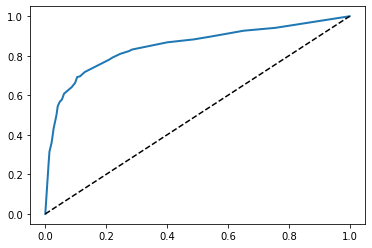

0.8486528657371482

In [573]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

y_scores = cross_val_predict(pipe_out, X_train, y_train, cv=3,
                             method="predict_proba")
                             #method="decision_function") #SGD
    
y_scores = y_scores[:, 1]   # score = proba of positive class

fpr, tpr, thresholds = roc_curve(y_train, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # Dashed diagonal
    [...] # Add axis labels and grid

plot_roc_curve(fpr, tpr)
plt.show()
# forest
# 0.856909225929727
# 0.8557619297938204 drop age

# knn
# 0.8406051048420068

# sgd
# n/a

roc_auc_score(y_train, y_scores)

## Submission

In [468]:
lin_class_test = LinearRegression()
svc_class_test = SVC(random_state=42)
forest_class_test = RandomForestClassifier(random_state=42)
knn_class_test = KNeighborsClassifier()
sgd_class_test = SGDClassifier(random_state=42, shuffle=True)

In [514]:
grid_search_test = GridSearchCV(knn_class_test, knn_param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True, verbose=1)

#col_trans.named_transformers_["cat"].handle_unknown = 'ignore' # for dropping attributes

main_pipeline_test = Pipeline([
    ('col', col_trans),
    ('dropper', AttributesDropper()),
    ('grid', grid_search_test)
])

full_pipeline_test = GridSearchCV(main_pipeline_test, param_drpr, cv=5,
                           scoring='neg_mean_squared_error',
                           verbose=2)#, error_score='raise')

In [515]:
all_test_data = load_csv_as_pd("test.csv")
all_test_data_pp = preprocess_data(all_test_data)

X_train_all = all_train_data_pp.drop(target_label_col, axis=1)
y_train_all = all_train_data_pp[target_label_col].copy()

pipe_out_test = full_pipeline_test.fit(X_train_all, y_train_all)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END ..........................dropper__min_importance=0; total time=   1.5s
Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END ..........................dropper__min_importance=0; total time=   1.5s
Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END ..........................dropper__min_importance=0; total time=   1.5s
Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END ..........................dropper__min_importance=0; total time=   1.5s
Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END ..........................dropper__min_importance=0; total time=   1.7s
Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END .....................dropper__min_importance=0.0002; total time=   1.7s
Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END ..................

In [516]:
print(full_pipeline_test.best_params_)
#print(full_pipeline_test.best_estimator_)
print(full_pipeline_test.best_estimator_.steps[2][1].best_params_)

#print(grid_search_test.named_steps['grid'].best_params_)
y_submission = pipe_out_test.predict(all_test_data_pp)
print(y_submission.shape)

df = pd.DataFrame(y_submission, columns=['Survived'])
df.insert(0, "PassengerId", all_test_data["PassengerId"], allow_duplicates=True)
df.to_csv("submission.csv", index=False)
df

{'dropper__min_importance': 0.0004}
{'n_neighbors': 10, 'weights': 'uniform'}
(418,)


,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


1. 0.75119: forest trained on subset of train.csv
2. 0.75598: forest trained on all data
3. 0.77751: knn .0001 drop?
4. 0.72966: sgd
5. 0.77751: knn .0003 drop
6. 0.77033: knn .00001 drop
7. 0.77751: knn .0004 drop